In [576]:
%load_ext autoreload
%autoreload 2

import sys
sys.path.append("./utils")

import numpy as np
import pandas as pd
import joblib
import pickle
import seaborn as sns
from utils.get_targets import get_first_threshold_bump, get_close_price_target
from stockstats import StockDataFrame
from matplotlib import pyplot as plt
import optuna
import random
from tqdm import tqdm

from stockstats import StockDataFrame

from sklearn.model_selection import train_test_split
from sklearn.utils.class_weight import compute_class_weight
from sklearn.metrics import confusion_matrix
from sklearn.metrics import mean_squared_error
from sklearn.model_selection import TimeSeriesSplit
from sklearn.decomposition import PCA
from sklearn.decomposition import KernelPCA
from sklearn.manifold import TSNE
from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import Pipeline

from catboost import CatBoostClassifier, CatBoostRegressor
from lightgbm import LGBMRegressor
from xgboost import XGBRegressor

pd.set_option("display.max_columns", None)
random.seed(42)

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [509]:
DATA_PATH = "./data/prices/AAPL_1minute_train.csv"
TEST_PATH = "./data/prices/AAPL_1minute_test.csv"
MODEL_PATH = "./aapl_trader_qc.txt"

TEST_RATIO = 0.2
TIME_LAG = 15

In [644]:
def prepare_dataset(path: str) -> pd.DataFrame:
    data = pd.read_csv(DATA_PATH, index_col=0)
    data = data.join(pd.Series(get_close_price_target(data, TIME_LAG), name="target"))
    data.dropna(inplace=True)
    
    return data

In [645]:
data = prepare_dataset(DATA_PATH)
data

,volume,open,close,high,low,date,ticker,target
0,207584.0,72.6325,72.5475,72.6350,72.5400,2020-05-04 18:06:00,AAPL,0.1425
1,135676.0,72.5450,72.5500,72.5800,72.5274,2020-05-04 18:07:00,AAPL,0.1300
2,82528.0,72.5575,72.5825,72.6050,72.5575,2020-05-04 18:08:00,AAPL,0.0855
3,142124.0,72.5825,72.5500,72.5900,72.5250,2020-05-04 18:09:00,AAPL,0.1250
4,131924.0,72.5450,72.6250,72.6250,72.5338,2020-05-04 18:10:00,AAPL,0.0500
...,...,...,...,...,...,...,...,...
326005,178709.0,171.0999,171.0498,171.1425,171.0200,2021-12-07 17:01:00,AAPL,0.0946
326006,157938.0,171.0500,170.9200,171.0700,170.9100,2021-12-07 17:02:00,AAPL,0.2620
326007,264638.0,170.9200,170.8200,170.9800,170.8100,2021-12-07 17:03:00,AAPL,0.3100
326008,194110.0,170.8300,170.9651,170.9700,170.8200,2021-12-07 17:04:00,AAPL,0.1649


In [646]:
dates = data.date.apply(lambda date: pd.Timestamp(date))
print(f"С {dates.min()} по {dates.max()}")

С 2020-05-04 18:06:00 по 2021-12-07 17:05:00


In [647]:
train_df, test_df = train_test_split(data, test_size=TEST_RATIO, shuffle=False)
train_df.reset_index(drop=True, inplace=True)
test_df.reset_index(drop=True, inplace=True)
display(train_df)
display(test_df)

,volume,open,close,high,low,date,ticker,target
0,207584.0,72.6325,72.5475,72.635,72.5400,2020-05-04 18:06:00,AAPL,0.1425
1,135676.0,72.5450,72.5500,72.580,72.5274,2020-05-04 18:07:00,AAPL,0.1300
2,82528.0,72.5575,72.5825,72.605,72.5575,2020-05-04 18:08:00,AAPL,0.0855
3,142124.0,72.5825,72.5500,72.590,72.5250,2020-05-04 18:09:00,AAPL,0.1250
4,131924.0,72.5450,72.6250,72.625,72.5338,2020-05-04 18:10:00,AAPL,0.0500
...,...,...,...,...,...,...,...,...
260803,448.0,145.6700,145.6700,145.670,145.6700,2021-08-10 21:19:00,AAPL,-0.0100
260804,353.0,145.6600,145.6600,145.660,145.6600,2021-08-10 21:20:00,AAPL,-0.0100
260805,628.0,145.6700,145.6700,145.670,145.6700,2021-08-10 21:21:00,AAPL,-0.0200
260806,1783.0,145.6700,145.6700,145.670,145.6700,2021-08-10 21:22:00,AAPL,-0.0100


,volume,open,close,high,low,date,ticker,target
0,2943.0,145.6500,145.6500,145.6500,145.6500,2021-08-10 21:24:00,AAPL,-0.0200
1,145.0,145.6500,145.6500,145.6500,145.6500,2021-08-10 21:25:00,AAPL,-0.0200
2,20263.0,145.6500,145.6500,145.6500,145.6000,2021-08-10 21:26:00,AAPL,-0.0200
3,259.0,145.6500,145.6500,145.6500,145.6500,2021-08-10 21:27:00,AAPL,0.0000
4,611.0,145.6500,145.6500,145.6500,145.6500,2021-08-10 21:28:00,AAPL,-0.0200
...,...,...,...,...,...,...,...,...
65197,178709.0,171.0999,171.0498,171.1425,171.0200,2021-12-07 17:01:00,AAPL,0.0946
65198,157938.0,171.0500,170.9200,171.0700,170.9100,2021-12-07 17:02:00,AAPL,0.2620
65199,264638.0,170.9200,170.8200,170.9800,170.8100,2021-12-07 17:03:00,AAPL,0.3100
65200,194110.0,170.8300,170.9651,170.9700,170.8200,2021-12-07 17:04:00,AAPL,0.1649


In [628]:
print(train_preprocessed_df.corr()["target"].sort_values(ascending=False)[:20].index.tolist())

['target', 'mdi', 'dx', 'adx', 'vr', 'volume', 'trix', 'middle_10_trix', 'dma', 'chop', 'pdi', 'cr', 'atr_5', 'high_-1_d', 'wt2', 'ppo', 'macd', 'atr', 'boll', 'close_10_smma']


In [515]:
feat_imp = [(imp, feat) for imp, feat in zip(cb.get_feature_importance(), train_preprocessed_df.drop(["target"], axis=1).columns)]
feat_imp.sort(reverse=True)
print(list(map(lambda x: x[1], feat_imp))[:30])

['chop_6', 'cci', 'mdi', 'cr-ma3', 'volume', 'close_-1_d', 'volume_10_mstd', 'volume_5_mstd', 'wt2', 'adxr', 'volume_5_ema', 'cr-ma1', 'dma', 'adx', 'middle_10_trix', 'vr', 'close_-5_d', 'pdi', 'dx', 'macds', 'atr_5', 'macdh', 'atr', 'volume_10_ema', 'close', 'cr', 'cr-ma2', 'mfi', 'low', 'volume']


In [648]:
def get_features(dataset: pd.DataFrame, train: bool = True) -> pd.DataFrame:
    
    initial_features = ["open", "close", "low", "high", "volume"]
    result_dataset = StockDataFrame(dataset.copy())
    
#     indicators = [
#         "change", "rsi", "rsi_6", "log-ret", "close_-10~0_min", "close_-10~0_max",
#         "stochrsi", "stochrsi_6", "wt1", "wt2", "close_10_smma",
#         "trix", "middle_10_trix", "tema", "middle_10_tema",
#         "vr", "wr", "wr_6", "atr", "atr_5",
#         "supertrend", "dma", "pdi", "mdi", "dx", "adx",
#         "cr", "boll", "macd", "ppo", "vwma", "chop", "mfi",
#         "cr_10_ema", "macd_10_ema", "ppo_10_ema", "chop_10_ema", "mfi_10_ema", "change_10_ema",
#         "close_10_kama", "open_10_kama", "volume_10_kama", "high_10_kama", "low_10_kama",
#         "volume_10_mstd", "volume_10_sma", "volume_20_mstd", "volume_20_sma", "volume_10_ema", "volume_20_sma",
#         "close_10_mstd", "close_10_sma", "close_20_mstd", "close_20_sma", "close_10_ema", "close_20_sma",
#         "open_10_mstd", "open_10_sma", "open_20_mstd", "open_20_sma", "open_10_ema", "open_20_sma",
#         "low_10_mstd", "low_10_sma", "low_20_mstd", "low_20_sma", "low_10_ema", "low_20_sma",
#         "high_10_mstd", "high_10_sma", "high_20_mstd", "high_20_sma", "high_10_ema", "high_20_sma",
#     ]

#     simple_indicators = [
#         "change", "log-ret",
#         "close_-1_d", "close_-5_d", "close_-10_d",
#         "close_-1_s", "close_-5_s", "close_-10_s",
#         "close_-10~0_min", "close_-10~0_max",
#         "volume_5_ema", "volume_10_ema", "volume_5_mstd", "volume_10_mstd",
#         "rsi", "rsi_6",
#         "stochrsi", "stochrsi_6",
#         "wt1", "wt2",
#         "trix", "middle_10_trix",
#         "tema", "middle_10_tema",
#         "vr",
#         "wr_6",
#         "cci", "cci_6",
#         "atr", "atr_5",
#         "supertrend",
#         "dma",
#         "pdi", "mdi", "dx", "adx", "adxr",
#         "cr", "cr-ma1", "cr-ma2", "cr-ma3",
#         "boll",
#         "macd", "macdh", "macds",
#         "ppo", "ppos", "ppoh",
#         "vwma", "vwma_6",
#         "chop", "chop_6",
#         "mfi", "mfi_6",
#     ]

    indicators = [
        "change", 
        "close_-1_d", "close_-5_d", "close_-10~0_min", "close_-10~0_max", "close_10_smma",
        "high_-1_d", "high_-5_d", "high_-10~0_min", "high_-10~0_max", "high_10_smma",
        "low_-1_d", "low_-5_d", "low_-10~0_min", "low_-10~0_max", "low_10_smma",
        "rsi", "rsi_6",
        "log-ret", 
        "stochrsi", "stochrsi_6",
        "wt1", "wt2",
        "trix", "middle_10_trix",
        "tema", "middle_10_tema",
        "vr",
        "wr", "wr_6",
        "atr", "atr_5",
        "supertrend",
        "dma", "pdi", "mdi", "dx", "adx",
        "cr", "boll", "macd", "ppo", "vwma", "chop", "mfi",
        "dma_5_ema", "dma_5_mstd",
        "pdi_5_ema", "pdi_5_mstd",
        "mdi_5_ema", "mdi_5_mstd",
        "dx_5_ema", "dx_5_mstd",
        "adx_5_ema", "adx_5_mstd",
        "cr_5_ema", "cr_5_mstd",
        "macd_5_ema", "macd_5_mstd",
        "ppo_5_ema", "ppo_5_mstd",
        "vwma_5_ema", "vwma_5_mstd",
        "chop_5_ema", "chop_5_mstd",
        "mfi_5_ema", "mfi_5_mstd",
    ]

    additional_columns = ["open", "close", "low", "high", "volume"]
    if train:
        additional_columns.append("target")
    return result_dataset[additional_columns + indicators]

In [649]:
train_preprocessed_df = get_features(train_df, train=True).dropna().reset_index(drop=True)
test_preprocessed_df = get_features(test_df, train=False).dropna().reset_index(drop=True)
test_preprocessed_df["target"] = test_df["target"]

display(train_preprocessed_df)
display(test_preprocessed_df)

,open,close,low,high,volume,target,change,close_-1_d,close_-5_d,close_-10~0_min,close_-10~0_max,close_10_smma,high_-1_d,high_-5_d,high_-10~0_min,high_-10~0_max,high_10_smma,low_-1_d,low_-5_d,low_-10~0_min,low_-10~0_max,low_10_smma,rsi,rsi_6,log-ret,stochrsi,stochrsi_6,wt1,wt2,trix,middle_10_trix,tema,middle_10_tema,vr,wr,wr_6,atr,atr_5,supertrend,dma,pdi,mdi,dx,adx,cr,boll,macd,ppo,vwma,chop,mfi,dma_5_ema,dma_5_mstd,pdi_5_ema,pdi_5_mstd,mdi_5_ema,mdi_5_mstd,dx_5_ema,dx_5_mstd,adx_5_ema,adx_5_mstd,cr_5_ema,cr_5_mstd,macd_5_ema,macd_5_mstd,ppo_5_ema,ppo_5_mstd,vwma_5_ema,vwma_5_mstd,chop_5_ema,chop_5_mstd,mfi_5_ema,mfi_5_mstd
0,72.5825,72.550,72.5250,72.5900,142124.0,0.1250,-0.044777,-0.0325,0.0000,72.5475,72.5825,72.557975,-0.0150,0.0000,72.58,72.6350,72.601109,-0.0325,0.0000,72.525,72.5575,72.537250,49.872123,46.998867,-0.000448,0.000000,0.000000,-32.513111,-53.321854,0.002145,-0.001058,72.558489,72.561963,130.937393,-77.272727,-77.272727,0.066125,0.064805,72.755876,0.000000,10.024040,19.414561,31.898665,49.862131,92.684109,72.557500,0.000345,0.000475,72.565276,33.686762,0.500000,0.000000,0.000000,8.137161,7.253725,11.506774,8.097380,48.540910,37.389686,65.050155,25.777826,116.406152,45.358006,0.000452,0.000496,0.000624,0.000684,72.567378,0.004123,22.844408,14.613975,0.500000,0.000000
1,72.5450,72.625,72.5338,72.6250,131924.0,0.0500,0.103377,0.0750,0.0000,72.5475,72.6250,72.574342,0.0350,0.0000,72.58,72.6350,72.606943,0.0088,0.0000,72.525,72.5575,72.536408,77.679095,78.522258,0.001033,55.472072,59.476824,9.843293,-37.530567,0.003430,0.000078,72.609023,72.582158,184.583354,-9.090909,-9.090909,0.071910,0.072657,72.755876,0.000000,19.511314,13.195099,19.311857,38.061743,124.391268,72.571000,0.002923,0.004027,72.570804,44.799510,0.500000,0.000000,0.000000,12.503542,8.687485,12.154898,7.291103,36.399611,35.884541,53.839584,26.868917,119.471528,39.282452,0.001401,0.001220,0.001930,0.001681,72.568693,0.003725,31.272670,17.612661,0.500000,0.000000
2,72.6199,72.670,72.6100,72.6871,278544.0,0.0200,0.061962,0.0450,0.1225,72.5475,72.6700,72.594758,0.0621,0.0521,72.58,72.6871,72.624050,0.0762,0.0700,72.525,72.6100,72.552114,83.568661,84.962019,0.000619,67.221155,71.627058,46.668591,4.439611,0.005351,0.002439,72.660002,72.627904,297.851299,-10.549044,-10.549044,0.072943,0.073861,72.755876,0.000000,34.483225,9.998384,55.044864,44.022345,182.640638,72.587500,0.006342,0.008736,72.594974,37.483060,0.500000,0.000000,0.000000,20.535216,12.726608,11.366879,5.003986,43.557268,31.254662,50.070881,24.786138,142.554376,40.856164,0.003206,0.002596,0.004417,0.003576,72.578296,0.012456,33.542030,12.737241,0.500000,0.000000
3,72.6775,72.700,72.6775,72.7238,325420.0,0.0214,0.041283,0.0300,0.1500,72.5475,72.7000,72.614931,0.0367,0.1438,72.58,72.7238,72.643170,0.0675,0.1501,72.525,72.6775,72.576148,86.185617,87.871299,0.000413,72.441715,77.116147,66.160218,22.539748,0.007252,0.005232,72.699005,72.675855,430.181037,-11.971831,-11.971831,0.069564,0.068784,72.755876,0.000000,39.655636,8.274753,65.471790,51.089326,225.524769,72.603571,0.009784,0.013475,72.621296,34.159685,0.500000,0.000000,0.000000,27.304903,12.872927,10.272095,5.136335,51.565131,18.340944,50.443034,9.867427,171.930489,51.517611,0.005535,0.003935,0.007624,0.005420,72.593520,0.023821,33.760714,7.515575,0.500000,0.000000
4,72.7000,72.725,72.6944,72.7575,266320.0,-0.0326,0.034388,0.0250,0.1425,72.5475,72.7250,72.634257,0.0337,0.1525,72.58,72.7575,72.663245,0.0169,0.1369,72.525,72.6944,72.596911,87.913197,89.837381,0.000344,75.888062,80.825656,74.919344,49.397862,0.008963,0.007865,72.728992,72.714054,538.478180,-13.978495,-13.978495,0.068532,0.067418,72.755876,0.000000,41.997857,6.756604,72.283134,57.779345,251.890799,72.618750,0.013124,0.018070,72.638993,32.818766,0.500000,0.000000,0.000000,32.401412,13.807466,9.052685,5.016638,58.900451,22.492278,53.040494,7.468349,199.666127,66.819847,0.008168,0.005133,0.011248,0.007067,72.609293,0.031790,33.433983,4.918105,0.500000,0.000000
...,...,...,...,...,.

,open,close,low,high,volume,change,close_-1_d,close_-5_d,close_-10~0_min,close_-10~0_max,close_10_smma,high_-1_d,high_-5_d,high_-10~0_min,high_-10~0_max,high_10_smma,low_-1_d,low_-5_d,low_-10~0_min,low_-10~0_max,low_10_smma,rsi,rsi_6,log-ret,stochrsi,stochrsi_6,wt1,wt2,trix,middle_10_trix,tema,middle_10_tema,vr,wr,wr_6,atr,atr_5,supertrend,dma,pdi,mdi,dx,adx,cr,boll,macd,ppo,vwma,chop,mfi,dma_5_ema,dma_5_mstd,pdi_5_ema,pdi_5_mstd,mdi_5_ema,mdi_5_mstd,dx_5_ema,dx_5_mstd,adx_5_ema,adx_5_mstd,cr_5_ema,cr_5_mstd,macd_5_ema,macd_5_mstd,ppo_5_ema,ppo_5_mstd,vwma_5_ema,vwma_5_mstd,chop_5_ema,chop_5_mstd,mfi_5_ema,mfi_5_mstd,target
0,145.6600,145.6600,145.6600,145.6600,1651.0,-0.006865,-0.0100,0.0100,145.6500,145.6700,145.657905,-0.0100,0.0100,145.65,145.6700,145.657905,-0.0100,0.0100,145.60,145.67,145.654234,62.446969,56.008147,-0.000069,0.000000,0.000000,56.373487,54.222970,0.000418,0.000597,145.664929,145.666824,105.262793,-14.285714,-50.000000,0.007696,0.007171,145.683087,0.000000,31.923345,64.577881,33.838467,41.379618,61.111111,145.656000,0.001567,0.001076,145.640627,5.059814,0.500000,0.000000,0.000000,29.619793,17.146352,66.885925,16.573856,38.297591,35.696839,58.696023,25.022618,59.763680,16.629588,0.001155,0.000745,0.000793,0.000511,145.639276,0.001598,1.755085,2.262818,0.500000,0.000000,-0.0200
1,145.6600,145.6600,145.6600,145.6600,496.0,0.000000,0.0000,0.0100,145.6500,145.6700,145.658211,0.0000,0.0100,145.65,145.6700,145.658211,0.0000,0.0100,145.60,145.67,145.655074,62.446969,56.008147,0.000000,0.000000,0.000000,49.508291,57.334029,0.000442,0.000630,145.661830,145.664896,105.173824,-14.285714,-50.000000,0.006710,0.005602,145.680129,0.000636,30.457181,61.611971,33.838467,39.115416,61.111111,145.656364,0.001419,0.000974,145.640946,5.059814,0.500000,0.000215,0.000285,29.906377,7.214862,65.080990,7.250078,36.771520,14.827831,51.994841,17.704124,60.224819,8.713548,0.001244,0.000500,0.000854,0.000343,145.639839,0.001219,2.886081,2.771374,0.500000,0.000000,-0.0200
2,145.6500,145.6500,145.6500,145.6500,672.0,-0.006865,-0.0100,-0.0100,145.6500,145.6700,145.657066,-0.0100,-0.0100,145.65,145.6700,145.657066,-0.0100,-0.0100,145.60,145.67,145.654367,43.501097,34.287567,-0.000069,0.000000,0.000000,30.257365,50.334265,0.000404,0.000573,145.653289,145.658589,100.567071,-28.571429,-100.000000,0.007109,0.006547,145.671326,0.001167,24.075796,71.564579,49.653489,42.234112,52.380952,145.655833,0.000742,0.000509,145.641144,9.522886,0.500000,0.000534,0.000528,27.928552,7.604413,67.280326,7.307863,41.141288,15.487728,48.683847,7.987996,57.564055,9.022103,0.001075,0.000384,0.000738,0.000264,145.640277,0.001108,5.137391,4.022534,0.500000,0.000000,-0.0200
3,145.6500,145.6500,145.6500,145.6550,1536.0,0.000000,0.0000,-0.0200,145.6500,145.6700,145.656119,0.0050,-0.0150,145.65,145.6700,145.656789,0.0000,-0.0200,145.60,145.67,145.653781,43.501097,34.287567,0.000000,0.000000,0.000000,18.705465,38.711152,0.000339,0.000485,145.649717,145.655296,100.540037,-28.571429,-100.000000,0.006865,0.006219,145.671326,0.001615,32.494028,62.402047,31.516603,39.094435,59.523810,145.655385,0.000230,0.000158,145.641644,11.571619,0.500000,0.000897,0.000714,29.468177,5.912435,65.635214,6.585010,37.895535,12.877250,45.449990,2.353660,58.224947,7.539766,0.000792,0.000634,0.000544,0.000435,145.640735,0.000808,7.307219,4.497964,0.500000,0.000000,0.0000
4,145.6600,145.6600,145.6600,145.6600,322.0,0.006866,0.0100,-0.0100,145.6500,145.6700,145.656622,0.0050,-0.0100,145.65,145.6700,145.657206,0.0100,-0.0100,145.65,145.67,145.654588,58.206610,57.834695,0.000069,26.027962,35.833597,21.707979,30.044775,0.000299,0.000431,145.655594,145.657150,102.538796,-14.285714,-50.000000,0.007212,0.007010,145.671326,0.002286,36.849385,50.246349,15.381883,32.197773,71.428571,145.655714,0.000423,0.000290,145.641825,15.364013,0.500000,0.001361,0.000879,31.947690,4.620912,60.465749,7.690168,30.332695,12.157553,40.998273,3.944079,62.660340,6.804138,0.000669,0.000594,0.000459,0.000408,145.641100,0.000494,1

## Обучение

In [651]:
(train_preprocessed_df == np.inf).sum()

open           0
close          0
low            0
high           0
volume         0
              ..
vwma_5_mstd    0
chop_5_ema     0
chop_5_mstd    0
mfi_5_ema      0
mfi_5_mstd     0
Length: 73, dtype: int64

In [652]:
X_train = train_preprocessed_df.drop(["target"], axis=1).to_numpy()
y_train = train_preprocessed_df["target"].to_numpy()

X_test = test_preprocessed_df.drop(["target"], axis=1).to_numpy()
y_test = test_preprocessed_df["target"].to_numpy()

X_train.shape, X_test.shape

((260703, 72), (65149, 72))

In [653]:
# cb = CatBoostRegressor()
# cb.fit(X_train, y_train)

In [674]:
def lgbm_objective(trial, X_train, y_train):
    NUM_FOLDS = 4
    PCA_COMPONENTS = 20
    lgbm_parameters = {
        "boosting_type": trial.suggest_categorical("boosting_type", ["gbdt", "goss"]),
        "objective": "mean_squared_error",
        "num_leaves": trial.suggest_int("num_leaves", 10, 100),
        "max_depth": trial.suggest_int("max_depth", 4, 20),
        "learning_rate": trial.suggest_float("learning_rate", 1e-5, 1e-2),
        "n_estimators": trial.suggest_int("n_estimators", 30, 200),
        "subsample": trial.suggest_float("subsample", 0.2, 1.),
        "colsample_bytree": trial.suggest_float("colsample_bytree", 0.2, 1.),
        "reg_lambda": trial.suggest_float("reg_lambda", 0.0, 3.0),
        "reg_alpha": trial.suggest_float("reg_alpha", 0.0, 3.0),
    }
    
    tscv = TimeSeriesSplit(n_splits=NUM_FOLDS)
    fold = 1
    loss = 0
    for train_index, test_index in (pbar := tqdm(tscv.split(X_train))):
#         pipe = Pipeline([("scaler", StandardScaler()), ("pca", PCA(n_components=PCA_COMPONENTS))])
        
        X_train_cv = X_train[train_index]
        X_test_cv = X_train[test_index]
        
        y_train_cv = y_train[train_index]
        y_test_cv = y_train[test_index]
        
        lgbm_regressor = LGBMRegressor(random_state=0, **lgbm_parameters)
        lgbm_regressor.fit(X_train_cv, y_train_cv)

        lgbm_predictions = lgbm_regressor.predict(X_test_cv)
        current_mse = mean_squared_error(y_test_cv, lgbm_predictions)
        loss += current_mse
        
        pbar.set_description(f"Fold: {fold}, loss: {current_mse}")
        fold += 1
        
    return loss / NUM_FOLDS

In [675]:
study = optuna.create_study()
study.optimize(lambda trial: lgbm_objective(trial, X_train, y_train), n_trials=50)

[I 2022-05-11 04:01:44,645] A new study created in memory with name: no-name-2da3fd29-0c9e-4161-9e5e-0c7dd9fa722f
Fold: 4, loss: 0.06358889361340071: : 4it [00:05,  1.38s/it]
[I 2022-05-11 04:01:50,191] Trial 0 finished with value: 0.12323615032463744 and parameters: {'boosting_type': 'goss', 'num_leaves': 78, 'max_depth': 9, 'learning_rate': 0.003473163841379837, 'n_estimators': 37, 'subsample': 0.8406480295744669, 'colsample_bytree': 0.8461614366085937, 'reg_lambda': 0.8313987511008796, 'reg_alpha': 1.4181967821794306}. Best is trial 0 with value: 0.12323615032463744.
Fold: 4, loss: 0.06942489051687971: : 4it [00:13,  3.36s/it]
[I 2022-05-11 04:02:03,663] Trial 1 finished with value: 0.12681694145147593 and parameters: {'boosting_type': 'gbdt', 'num_leaves': 82, 'max_depth': 14, 'learning_rate': 0.003916037501874595, 'n_estimators': 126, 'subsample': 0.38837438674821617, 'colsample_bytree': 0.8505110829124205, 'reg_lambda': 0.6231499089883025, 'reg_alpha': 2.5570330346848396}. Best i

Fold: 4, loss: 0.07136458644952001: : 4it [00:07,  1.82s/it]
[I 2022-05-11 04:03:58,159] Trial 17 finished with value: 0.12707466130144324 and parameters: {'boosting_type': 'gbdt', 'num_leaves': 49, 'max_depth': 7, 'learning_rate': 0.007635070082406072, 'n_estimators': 131, 'subsample': 0.31602637117609067, 'colsample_bytree': 0.26218512723675075, 'reg_lambda': 1.916687605637204, 'reg_alpha': 0.37547434039335487}. Best is trial 10 with value: 0.12285122839817066.
Fold: 4, loss: 0.0629332244704726: : 4it [00:06,  1.53s/it] 
[I 2022-05-11 04:04:04,343] Trial 18 finished with value: 0.12285185084174459 and parameters: {'boosting_type': 'gbdt', 'num_leaves': 32, 'max_depth': 6, 'learning_rate': 0.00011190649881937545, 'n_estimators': 61, 'subsample': 0.5541670124735052, 'colsample_bytree': 0.7126750192007527, 'reg_lambda': 1.1869863529850782, 'reg_alpha': 1.7993453404060515}. Best is trial 10 with value: 0.12285122839817066.
Fold: 4, loss: 0.06480955322972103: : 4it [00:06,  1.54s/it]
[I 2

Fold: 4, loss: 0.0654241499319847: : 4it [00:06,  1.71s/it] 
[I 2022-05-11 04:06:02,404] Trial 34 finished with value: 0.12394014799813954 and parameters: {'boosting_type': 'gbdt', 'num_leaves': 26, 'max_depth': 10, 'learning_rate': 0.0037873595974895085, 'n_estimators': 159, 'subsample': 0.7700783812910138, 'colsample_bytree': 0.20034468827197954, 'reg_lambda': 2.064907084033015, 'reg_alpha': 1.3489159192403584}. Best is trial 23 with value: 0.12284940676714988.
Fold: 4, loss: 0.06404601594968577: : 4it [00:09,  2.39s/it]
[I 2022-05-11 04:06:12,026] Trial 35 finished with value: 0.12352518148477405 and parameters: {'boosting_type': 'gbdt', 'num_leaves': 10, 'max_depth': 16, 'learning_rate': 0.0007835387276012413, 'n_estimators': 176, 'subsample': 0.6920648093230146, 'colsample_bytree': 0.9927229388601568, 'reg_lambda': 1.7559341976590068, 'reg_alpha': 2.456069720970192}. Best is trial 23 with value: 0.12284940676714988.
Fold: 4, loss: 0.06530808004855966: : 4it [00:12,  3.10s/it]
[I 2

All indicators, TIME_LAG = 15, without PCA: 0.10289600234229324  
All indicators, TIME_LAG = 15, with PCA: 0.10287984195007314  
More indicators, TIME_LAG = 15, with PCA(6): 0.07087464016871625

In [676]:
best_lgbm_params = study.best_params

In [677]:
lgbm_regressor = LGBMRegressor(random_state=0, **best_lgbm_params)

lgbm_regressor.fit(X_train, y_train)

lgbm_predictions = lgbm_regressor.predict(X_test)
mean_squared_error(y_test, lgbm_predictions)

0.10287289060363457

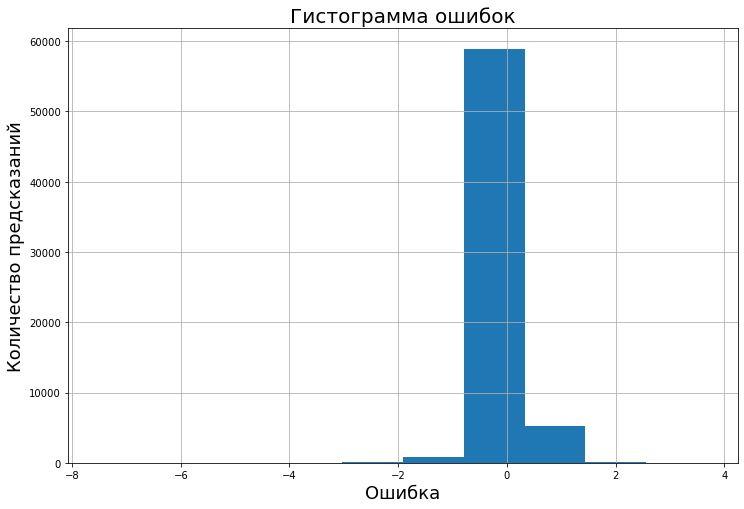

In [678]:
plt.figure(figsize=(12, 8))

plt.hist(y_test - lgbm_predictions)
plt.title("Гистограмма ошибок", fontsize=20)

plt.xlabel("Ошибка", fontsize=18)
plt.ylabel("Количество предсказаний", fontsize=18)

plt.grid()
plt.show()

In [679]:
lgbm_predictions

array([0.00424738, 0.00424738, 0.00424893, ..., 0.00422033, 0.00421877,
       0.00416177])

In [680]:
std = lgbm_predictions.std()
order_threshold = np.sqrt(std ** 2 / 0.2)

In [681]:
class_predictions = np.zeros(len(y_test))
class_predictions[lgbm_predictions > order_threshold] = 1
class_predictions[lgbm_predictions < -order_threshold] = 2

true_classes = np.zeros(len(y_test))
true_classes[y_test > order_threshold] = 1
true_classes[y_test < -order_threshold] = 2

confusion_matrix(true_classes, class_predictions)

array([[    0,  1790,     0],
       [    0, 32207,     0],
       [    0, 31152,     0]], dtype=int64)

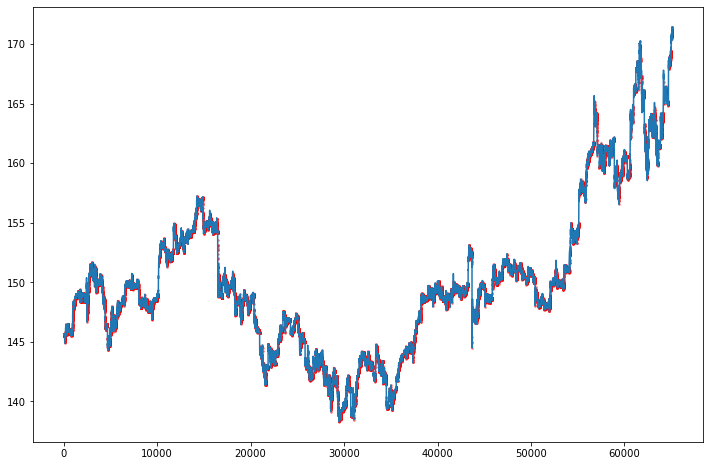

In [575]:
plt.figure(figsize=(12, 8))
plt.plot(test_preprocessed_df["close"])
buy_predictions = class_predictions == 1
plt.scatter(np.arange(len(test_preprocessed_df))[buy_predictions], test_preprocessed_df["close"].iloc[buy_predictions],
           color="red", alpha=0.4, s=3)

In [275]:
lgbm_regressor.booster_.save_model(MODEL_PATH)

In [106]:
data = prepare_dataset(DATA_PATH)
data_preprocessed = get_features(data, train=True).reset_index(drop=True)
data_preprocessed

,open,close,low,high,volume,target,change,close_-1_d,high_-1_d,close_-5_d,high_-5_d,rsi,rsi_6,log-ret,close_-10~0_min,close_-10~0_max,stochrsi,stochrsi_6,wt1,wt2,close_10_smma,trix,middle_10_trix,tema,middle_10_tema,vr,vr_6,wr,wr_6,atr,atr_5,supertrend,dma,pdi,mdi,dx,adx,cr,boll,macd,ppo,vwma,chop,mfi
0,72.6325,72.5475,72.5400,72.6350,207584.0,0.1425,0.000000,0.0000,0.0000,0.0000,0.0000,NaN,NaN,0.000000,72.5475,72.5475,NaN,NaN,NaN,NaN,72.547500,0.000000,0.000000,72.547500,72.574167,100.000000,100.000000,-92.105263,-92.105263,0.095000,0.095000,72.872500,0.000000,0.000000,0.000000,NaN,NaN,178.048780,72.547500,0.000000,0.000000,72.574167,0.000000,0.500000
1,72.5450,72.5500,72.5274,72.5800,135676.0,0.1300,0.003446,0.0025,-0.0550,0.0000,0.0000,100.000000,100.000000,0.000034,72.5475,72.5500,NaN,NaN,-121.212121,-121.212121,72.548816,0.000548,-0.004975,72.549840,72.554444,230.719131,230.719131,-78.996283,-78.996283,0.073015,0.071444,72.772744,0.000000,0.000000,9.244699,100.000000,100.000000,82.372323,72.548750,0.000056,0.000077,72.565590,11.977203,0.500000
2,72.5575,72.5825,72.5575,72.6050,82528.0,0.0855,0.044797,0.0325,0.0250,0.0000,0.0000,100.000000,100.000000,0.000448,72.5475,72.5825,NaN,NaN,-6.240329,-63.726225,72.561245,0.003069,-0.001092,72.577908,72.574144,310.232002,310.232002,-48.791822,-48.791822,0.066560,0.064705,72.772744,0.000000,14.348132,6.267264,39.198218,64.532294,147.281713,72.560000,0.001079,0.001487,72.568706,23.978749,0.500000
3,72.5825,72.5500,72.5250,72.5900,142124.0,0.1250,-0.044777,-0.0325,-0.0150,0.0000,0.0000,49.872123,46.998867,-0.000448,72.5475,72.5825,0.000000,0.000000,-32.513111,-53.321854,72.557975,0.002145,-0.001058,72.558489,72.561963,130.937393,130.937393,-77.272727,-77.272727,0.066125,0.064805,72.755876,0.000000,10.024040,19.414561,31.898665,49.862131,92.684109,72.557500,0.000345,0.000475,72.565276,33.686762,0.500000
4,72.5450,72.6250,72.5338,72.6250,131924.0,0.0500,0.103377,0.0750,0.0350,0.0000,0.0000,77.679095,78.522258,0.001033,72.5475,72.6250,55.472072,59.476824,9.843293,-37.530567,72.574342,0.003430,0.000078,72.609023,72.582158,184.583354,184.583354,-9.090909,-9.090909,0.071910,0.072657,72.755876,0.000000,19.511314,13.195099,19.311857,38.061743,124.391268,72.571000,0.002923,0.004027,72.570804,44.799510,0.500000
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
326005,171.0999,171.0498,171.0200,171.1425,178709.0,0.0946,-0.029340,-0.0502,0.0425,-0.0452,-0.1425,45.605985,32.501878,-0.000293,171.0498,171.4600,0.000000,14.417344,-2.394341,6.290966,171.144033,0.004603,0.002477,171.045904,171.048139,138.768470,32.892317,-93.483490,-88.754717,0.125381,0.120238,171.436809,0.221860,16.478051,26.496025,23.311668,29.410848,105.319279,171.197255,0.025616,0.014969,171.235975,50.984534,0.511754
326006,171.0500,170.9200,170.9100,171.0700,157938.0,0.2620,-0.075884,-0.1298,-0.0725,-0.1700,-0.0590,39.115809,21.989614,-0.000759,170.9200,171.4600,0.000000,0.000000,-10.824651,-0.370048,171.121630,0.003059,0.000653,170.948909,170.990933,118.337876,38.446176,-98.237264,-96.078431,0.127854,0.128191,171.373562,0.166860,14.004777,33.990506,41.641028,32.905185,82.607245,171.186215,0.005552,0.003245,171.227182,44.915452,0.457595
326007,170.9200,170.8200,170.8100,170.9800,264638.0,0.3100,-0.058507,-0.1000,-0.0900,-0.2900,-0.1700,34.985073,16.927901,-0.000585,170.8200,171.4470,0.000000,0.000000,-19.889893,-7.601907,171.091467,0.001258,-0.001441,170.840964,170.912054,98.311709,37.684634,-98.501424,-97.183099,0.130865,0.136552,171.287594,0.102660,11.858262,38.969425,53.339360,38.743521,70.936674,171.166465,-0.018208,-0.010642,171.200411,41.137445,0.403314
326008,170.8300,170.9651,170.8200,170.9700,194110.0,0.1649,0.084943,0.1451,-0.0100,-0.1015,-0.1950,44.193983,40.696706,0.000849,170.8200,171.3050,25.080943,100.000000,-24.269299,-14.344546,171.078830,-0.000280,-0.003321,170.903536,170.885100,112.57

In [107]:
X = data_preprocessed.drop(["target"], axis=1)
y = data_preprocessed["target"]

In [108]:
lgbm_regressor = LGBMRegressor(random_state=0, **best_lgbm_params)
lgbm_regressor.fit(X, y)
lgbm_regressor.booster_.save_model(MODEL_PATH)

In [179]:
best_lgbm_params

{'boosting_type': 'goss',
 'num_leaves': 48,
 'max_depth': 11,
 'learning_rate': 6.272494871474194e-05,
 'n_estimators': 68,
 'subsample': 0.7358650761565397,
 'colsample_bytree': 0.20095533038115,
 'reg_lambda': 0.28880972586714904,
 'reg_alpha': 0.00021048428963572896}